In [1]:
try:
    # Essential imports
    import os
    import sys
    import glob
    import h5py
    import logging
    import rasterio
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from collections import defaultdict
    from pprint import pprint
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from PIL import Image
    import json
    from pathlib import Path
    from scipy import stats
    from rasterio.mask import mask
    from shapely.wkt import dumps, loads
    from shapely.geometry import mapping, Polygon, MultiPolygon
    from tqdm import tqdm
except Exception as e:
    print(f"Error : {e}")

In [2]:
# Create project directory structure
project_dir = Path("../Solutions/Land_Change_Monitoring")
subdirs = [
    "../Datasets/Sentinel-2/",           # Original GeoJSON and Sentinel-2 data
    "../Datasets/Testing/Processed",     # Processed and grouped events
    "../Datasets/Testing/Samples",       # Our sampled datasets
    "../Datasets/Testing/Tiles",         # Generated image tiles
    "../Docs/Diagrams",                             # Results and visualizations
    "../Models",                                    # Trained models
    "../Docs/Logs"                                  # Processing logs
]

# Create directories if they don't exist
for subdir in subdirs:
    Path(subdir).mkdir(parents=True, exist_ok=True)

# Set up logging
logging.basicConfig(
    filename=Path("../Docs/Logs/processing.log"),
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Print created directory structure for verification
print("Created directory structure:")
for subdir in subdirs:
    if Path(subdir).exists():
        print(f"✓ {subdir}")
    else:
        print(f"✗ {subdir}")

Created directory structure:
✓ ../Datasets/Sentinel-2/
✓ ../Datasets/Testing/Processed
✓ ../Datasets/Testing/Samples
✓ ../Datasets/Testing/Tiles
✓ ../Docs/Diagrams
✓ ../Models
✓ ../Docs/Logs


In [3]:
# Print the PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if running in Google Colab
if "google.colab" in str(get_ipython()):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = 'cpu'
        print("GPU not available in Colab, consider enabling a GPU runtime.")
# Running on a local machine
else:
    if torch.backends.mps.is_available():
        device = 'mps'
        print(f"Is Apple MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
        print(f"Is Apple MPS available? {torch.backends.mps.is_available()}")
    elif torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

# TODO: Add support for AMD ROCm GPU if needed

# Print the device being used
print(f"Using device: {device}")

PyTorch version: 2.5.1
Is Apple MPS (Metal Performance Shader) built? True
Is Apple MPS available? True
Using device: mps


In [4]:
# Set the path to the GeoJSON file
base_path = Path('../Datasets/Sentinel-2')
geojson_path = Path('../Datasets/BoundingBox/deforestation.geojson')
safe_dirs = list(base_path.glob("*/*.SAFE"))

In [5]:
# Load the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Display GeoJSON information
print("GeoJSON Information:", len(gdf))
print("-" * 50)
print(gdf.info())
print("\nFirst few records:")
print(gdf.head())

# Get the bounding box coordinates
bbox = gdf.total_bounds
print("\nBounding Box (minx, miny, maxx, maxy):")
print(bbox)

# Display basic information about the GeoJSON
print("\nGeoJSON CRS:", gdf.crs)
print("Number of features:", len(gdf))
print("Columns:", gdf.columns.tolist())
print("First geometry type:", gdf.geometry.iloc[0].geom_type)

GeoJSON Information: 5696
--------------------------------------------------
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   img_date  5696 non-null   datetime64[ms]
 1   tile      5696 non-null   object        
 2   geometry  5696 non-null   geometry      
dtypes: datetime64[ms](1), geometry(1), object(1)
memory usage: 133.6+ KB
None

First few records:
    img_date   tile                                           geometry
0 2016-04-09  36UXA  POLYGON ((35.7913 50.17406, 35.79277 50.17354,...
1 2016-04-09  36UXA  POLYGON ((35.77653 50.10271, 35.7781 50.10318,...
2 2016-04-09  36UXA  POLYGON ((35.78621 50.01277, 35.78616 50.01369...
3 2016-04-09  36UXA  POLYGON ((35.78007 50.00556, 35.78189 50.00557...
4 2016-04-09  36UXA  POLYGON ((35.79781 49.99568, 35.79908 49.99582...

Bounding Box (minx, miny, maxx, maxy):
[34.37579618 4

In [6]:
# Ensure 'img_date' is in datetime format if it exists
if 'img_date' in gdf.columns:
    gdf['img_date'] = pd.to_datetime(gdf['img_date'], errors='coerce')

    # Drop rows with invalid dates if any
    gdf = gdf.dropna(subset=['img_date'])

    # Get unique dates and sort them
    unique_dates = gdf['img_date'].dt.date.unique()
    unique_dates.sort()

    date_counts = gdf['img_date'].dt.date.value_counts().sort_index()
    print("Occurrences of each 'img_date':")
    print(date_counts)
else:
    print("'img_date' column not found in the GeoDataFrame.")

Occurrences of each 'img_date':
img_date
2016-01-03    3122
2016-02-12       6
2016-04-09      10
2016-05-22       2
2016-06-18       2
              ... 
2019-08-25      34
2019-08-30      49
2019-09-04      20
2019-09-09      34
2019-10-26       2
Name: count, Length: 93, dtype: int64


In [7]:
# Function to reduce geometry precision
def reduce_precision(geometry, decimal_places=5):
    return loads(dumps(geometry, rounding_precision=decimal_places))

# Apply precision reduction to all geometries
gdf['geometry'] = gdf['geometry'].apply(lambda geom: reduce_precision(geom))

# Now check for duplicates again
duplicate_geometries = gdf[gdf.geometry.duplicated(keep=False)]
print("Duplicate geometries after reducing precision:")
print(duplicate_geometries)

Duplicate geometries after reducing precision:
       img_date   tile                                           geometry
0    2016-04-09  36UXA  POLYGON ((35.7913 50.17406, 35.79277 50.17354,...
1    2016-04-09  36UXA  POLYGON ((35.77653 50.10271, 35.7781 50.10318,...
2    2016-04-09  36UXA  POLYGON ((35.78621 50.01277, 35.78616 50.01369...
3    2016-04-09  36UXA  POLYGON ((35.78007 50.00556, 35.78189 50.00557...
4    2016-04-09  36UXA  POLYGON ((35.79781 49.99568, 35.79908 49.99582...
...         ...    ...                                                ...
5691 2019-09-09  36UYA  POLYGON ((36.37494 50.17378, 36.37506 50.17376...
5692 2019-09-09  36UYA  POLYGON ((36.37849 50.17354, 36.37851 50.17352...
5693 2019-09-09  36UYA  POLYGON ((35.91477 50.22407, 35.91472 50.22394...
5694 2019-10-26  36UYA  POLYGON ((36.88312 50.26589, 36.88408 50.26489...
5695 2019-10-26  36UYA  POLYGON ((36.88312 50.26589, 36.88408 50.26489...

[3572 rows x 3 columns]


In [8]:
# Drop duplicates based on geometry
# gdf = gdf.drop_duplicates(subset='geometry')

# Save the cleaned GeoDataFrame to a new GeoJSON file
# gdf.to_file("deforestation_unique.geojson", driver='GeoJSON')

print(f"Number of unique geometries: {len(gdf)}")

Number of unique geometries: 5696


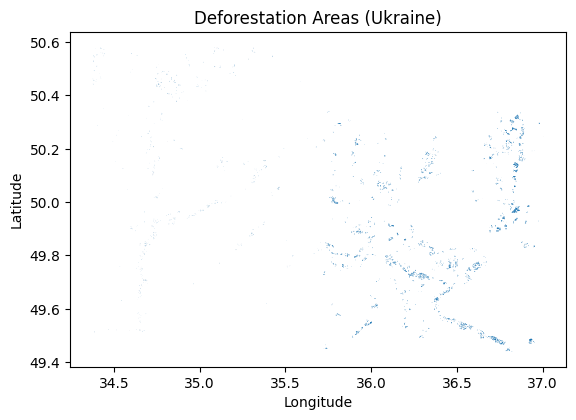

In [9]:
# Plot the geospatial data
gdf.plot()
plt.title('Deforestation Areas (Ukraine)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Deforestation events by year and month:
month    1    2    3    4   5    6    7    8    9   10  11  12
year                                                          
2016   3122    6    0   10   2   34   40   56    0  28   2  18
2017      0    2    0    0   0    0    0   13   55  17  86   0
2018     47  113   45   86  50  217  169  480  117   0   0   0
2019      0    2  227  240  34  127   59  136   54   2   0   0

Deforestation events by tile:
tile
36UYA    3836
36UXA    1860
Name: count, dtype: int64


<Figure size 1200x600 with 0 Axes>

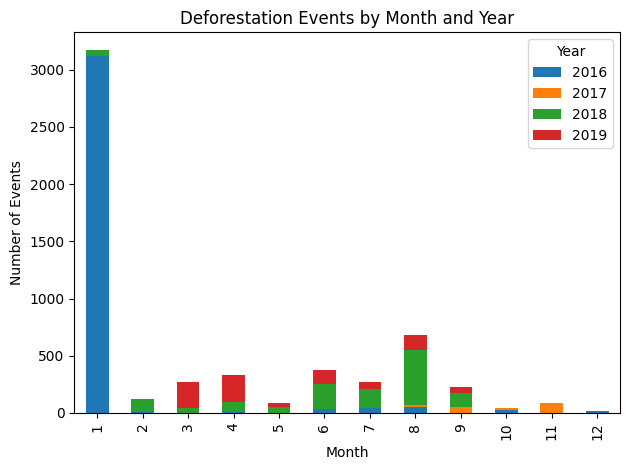

In [10]:
# Analyze temporal distribution
gdf['year'] = gdf['img_date'].dt.year
gdf['month'] = gdf['img_date'].dt.month

# Create year-month summary
temporal_dist = gdf.groupby(['year', 'month']).size().unstack(fill_value=0)
print("Deforestation events by year and month:")
print(temporal_dist)

# Distribution by tile
print("\nDeforestation events by tile:")
print(gdf['tile'].value_counts())

# Create a monthly summary plot
plt.figure(figsize=(12, 6))
temporal_dist.T.plot(kind='bar', stacked=True)
plt.title('Deforestation Events by Month and Year')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

Polygon area statistics (square meters):
count      5696.000000
mean      23829.958000
std       39183.595664
min          14.456997
25%        3083.167251
50%       12765.047788
75%       29428.937089
max      672740.531111
Name: area, dtype: float64


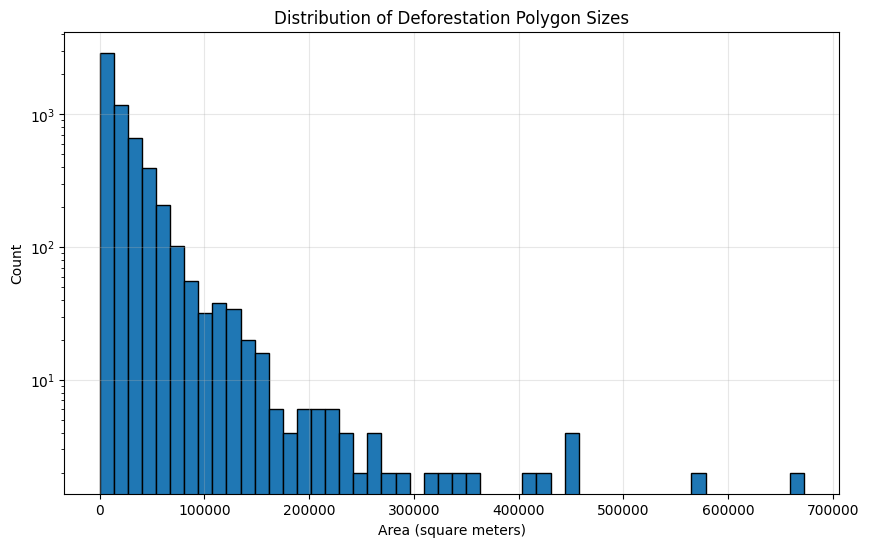

Shape complexity statistics (1.0 = perfect square):
count    5696.000000
mean        1.236106
std         0.255104
min         0.911006
25%         1.055388
50%         1.163420
75%         1.339636
max         3.090091
Name: complexity, dtype: float64


In [11]:
# Calculate area of each polygon in square meters
# Converting to UTM projection for accurate area and perimeter calculation
gdf['area'] = gdf.geometry.to_crs({'proj':'utm', 'zone':36, 'ellps':'WGS84'}).area
gdf['perimeter'] = gdf.geometry.to_crs({'proj':'utm', 'zone':36, 'ellps':'WGS84'}).length

# Basic statistics of polygon sizes
print("Polygon area statistics (square meters):")
print(gdf['area'].describe())

# Create histogram of polygon sizes
plt.figure(figsize=(10, 6))
plt.hist(gdf['area'], bins=50, edgecolor='black')
plt.title('Distribution of Deforestation Polygon Sizes')
plt.xlabel('Area (square meters)')
plt.ylabel('Count')
plt.yscale('log')  # Using log scale for better visualization
plt.grid(True, alpha=0.3)
plt.show()

# Calculate basic shape metrics
gdf['complexity'] = gdf['perimeter'] / (4 * np.sqrt(gdf['area']))

print("Shape complexity statistics (1.0 = perfect square):")
print(gdf['complexity'].describe())

In [12]:
# Reproject to UTM Zone 36N
deforestation_data_utm = gdf.to_crs(epsg=32636)

# Recalculate statistics in UTM projection
polygon_areas = deforestation_data_utm.geometry.area  # now in square meters
polygon_bounds = deforestation_data_utm.geometry.bounds

# Calculate statistics
max_width = (polygon_bounds.maxx - polygon_bounds.minx).max()
max_height = (polygon_bounds.maxy - polygon_bounds.miny).max()
mean_area = polygon_areas.mean()
median_area = polygon_areas.median()

print(f"Polygon Statistics:")
print(f"Mean area: {mean_area/10000:.2f} hectares")
print(f"Median area: {median_area/10000:.2f} hectares")
print(f"Max width: {max_width:.2f} meters")
print(f"Max height: {max_height:.2f} meters")

# Calculate optimal mesh size based on polygon distribution
hist, bins = np.histogram(polygon_areas, bins=20)
print("\nArea Distribution (hectares):")
for i in range(len(hist)):
    if hist[i] > 0:
        print(f"{bins[i]/10000:.2f} - {bins[i+1]/10000:.2f}: {hist[i]} polygons")

# Additional useful statistics
print("\nAdditional Statistics:")
print(f"Total number of polygons: {len(deforestation_data_utm)}")
print(f"Total area of deforestation: {polygon_areas.sum()/10000:.2f} hectares")
print(f"95th percentile area: {np.percentile(polygon_areas, 95)/10000:.2f} hectares")

Polygon Statistics:
Mean area: 2.38 hectares
Median area: 1.28 hectares
Max width: 1634.36 meters
Max height: 1399.25 meters

Area Distribution (hectares):
0.00 - 3.37: 4557 polygons
3.37 - 6.73: 779 polygons
6.73 - 10.09: 174 polygons
10.09 - 13.46: 88 polygons
13.46 - 16.82: 38 polygons
16.82 - 20.18: 14 polygons
20.18 - 23.55: 16 polygons
23.55 - 26.91: 6 polygons
26.91 - 30.27: 4 polygons
30.27 - 33.64: 4 polygons
33.64 - 37.00: 4 polygons
40.37 - 43.73: 4 polygons
43.73 - 47.09: 4 polygons
57.18 - 60.55: 2 polygons
63.91 - 67.27: 2 polygons

Additional Statistics:
Total number of polygons: 5696
Total area of deforestation: 13573.54 hectares
95th percentile area: 7.58 hectares


In [13]:
def collect_jp2_files(base_dir):
    jp2_files = []  # Create empty list to store paths
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".jp2"):
                full_path = os.path.join(root, file)
                jp2_files.append(full_path)
    return jp2_files


jp2_files = collect_jp2_files(base_path)

# Print count
print(f"Total files found: {len(jp2_files)}\n")

# Print all paths
print("Found .jp2 files:")
for path in jp2_files:
    print(path)

Total files found: 750

Found .jp2 files:
../Datasets/Sentinel-2/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_B10.jp2
../Datasets/Sentinel-2/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_B04.jp2
../Datasets/Sentinel-2/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_B05.jp2
../Datasets/Sentinel-2/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_B11.jp2
../Datasets/Sentinel-2/S2B

In [14]:
from pathlib import Path
import pandas as pd
from datetime import datetime
import re

def analyze_sentinel_structure(base_path):
    """
    Analyzes Sentinel-2 dataset structure and returns key information
    
    Args:
        base_path (str): Path to the Sentinel-2 dataset directory
    
    Returns:
        pd.DataFrame: DataFrame containing image metadata
    """
    # Initialize lists to store metadata
    metadata = []
    
    # Convert to Path object
    base = Path(base_path)
    
    # Pattern for date extraction
    date_pattern = r'(\d{8}T\d{6})'
    
    # Iterate through all .SAFE directories
    for safe_dir in base.glob('*/*.SAFE'):
        # Extract metadata from directory name
        dir_name = safe_dir.parent.name
        
        # Extract date using regex
        date_match = re.search(date_pattern, dir_name)
        if date_match:
            acquisition_date = datetime.strptime(date_match.group(1), '%Y%m%dT%H%M%S')
        else:
            acquisition_date = None
            
        # Get satellite (S2A or S2B)
        satellite = dir_name[:3]
        
        # Get tile ID
        tile_match = re.search(r'T(\d{2}[A-Z]{3})', dir_name)
        tile_id = tile_match.group(1) if tile_match else None
        
        # Count number of bands
        bands = list(safe_dir.glob('GRANULE/*/IMG_DATA/*.jp2'))
        num_bands = len([b for b in bands if not b.name.endswith('TCI.jp2')])
        
        metadata.append({
            'satellite': satellite,
            'acquisition_date': acquisition_date,
            'tile_id': tile_id,
            'num_bands': num_bands,
            'path': safe_dir
        })
    
    # Create DataFrame
    df = pd.DataFrame(metadata)
    df = df.sort_values('acquisition_date')
    
    return df

# Usage example:
df = analyze_sentinel_structure(base_path)

# Display basic statistics
print("Dataset Summary:")
print(f"Total number of images: {len(df)}")
print("\nAcquisitions by satellite:")
print(df['satellite'].value_counts())
print("\nDate range:")
print(f"First acquisition: {df['acquisition_date'].min()}")
print(f"Last acquisition: {df['acquisition_date'].max()}")

# Display the DataFrame
df.head()

Dataset Summary:
Total number of images: 50

Acquisitions by satellite:
satellite
S2A    33
S2B    17
Name: count, dtype: int64

Date range:
First acquisition: 2016-02-12 08:40:52
Last acquisition: 2019-09-09 08:35:59


,satellite,acquisition_date,tile_id,num_bands,path
3,S2A,2016-02-12 08:40:52,36UYA,13,../Datasets/Sentinel-2/S2A_MSIL1C_20160212T084...
33,S2A,2016-03-30 08:25:42,36UYA,13,../Datasets/Sentinel-2/S2A_MSIL1C_20160330T082...
15,S2A,2016-04-05 08:50:12,36UYA,13,../Datasets/Sentinel-2/S2A_MSIL1C_20160405T085...
7,S2A,2016-05-02 08:36:02,36UYA,13,../Datasets/Sentinel-2/S2A_MSIL1C_20160502T083...
14,S2A,2016-05-09 08:26:12,36UYA,13,../Datasets/Sentinel-2/S2A_MSIL1C_20160509T082...


In [15]:
def get_band_statistics(image_path):
    """Get statistics for specific bands in an image"""
    band_paths = Path(image_path).glob('GRANULE/*/IMG_DATA/*.jp2')
    bands = {}
    for band_path in band_paths:
        band_name = re.search(r'B\d{2}|B8A', band_path.name)
        if band_name:
            bands[band_name.group(0)] = str(band_path)
    return dict(sorted(bands.items()))

def get_quality_masks(image_path):
    """Get list of quality masks for an image"""
    mask_paths = Path(image_path).glob('GRANULE/*/QI_DATA/*.gml')
    return [p.name for p in mask_paths]

# Example usage:
image_path = df.iloc[0]['path']
print("Band files in first image:")
for band, path in get_band_statistics(image_path).items():
    print(f"{band}: {path}")

Band files in first image:
B01: ../Datasets/Sentinel-2/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_B01.jp2
B02: ../Datasets/Sentinel-2/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_B02.jp2
B03: ../Datasets/Sentinel-2/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_B03.jp2
B04: ../Datasets/Sentinel-2/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_B04.jp2
B05: ../Datasets/Sent

In [16]:
# Get the first image directory to analyze bands
first_image = safe_dirs[0]
img_data_path = list((first_image / "GRANULE").glob("*"))[0] / "IMG_DATA"
band_files = list(img_data_path.glob("*.jp2"))

# Extract band information
band_info = []
for band_file in band_files:
    band_name = band_file.name.split('_')[-1].split('.')[0]
    
    # Open the band file to get metadata
    with rasterio.open(band_file) as src:
        band_info.append({
            'band': band_name,
            'width': src.width,
            'height': src.height,
            'dtype': src.dtypes[0],
            'resolution': src.res[0]  # pixel size in meters
        })

# Create DataFrame with band information
df_bands = pd.DataFrame(band_info)
print("Band Information:")
print("-" * 50)
print(df_bands.sort_values('band'))

# Count number of files per image
print("\nNumber of files per image:")
print(len(band_files))

# Print list of unique bands
print("\nAvailable bands:")
unique_bands = sorted(list(df_bands['band'].unique()))
print(unique_bands)

Band Information:
--------------------------------------------------
   band  width  height   dtype  resolution
9   B01   1830    1830  uint16        60.0
7   B02  10980   10980  uint16        10.0
8   B03  10980   10980  uint16        10.0
1   B04  10980   10980  uint16        10.0
2   B05   5490    5490  uint16        20.0
6   B06   5490    5490  uint16        20.0
4   B07   5490    5490  uint16        20.0
10  B08  10980   10980  uint16        10.0
12  B09   1830    1830  uint16        60.0
0   B10   1830    1830  uint16        60.0
3   B11   5490    5490  uint16        20.0
5   B12   5490    5490  uint16        20.0
13  B8A   5490    5490  uint16        20.0
11  TCI  10980   10980   uint8        10.0

Number of files per image:
14

Available bands:
['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B8A', 'TCI']


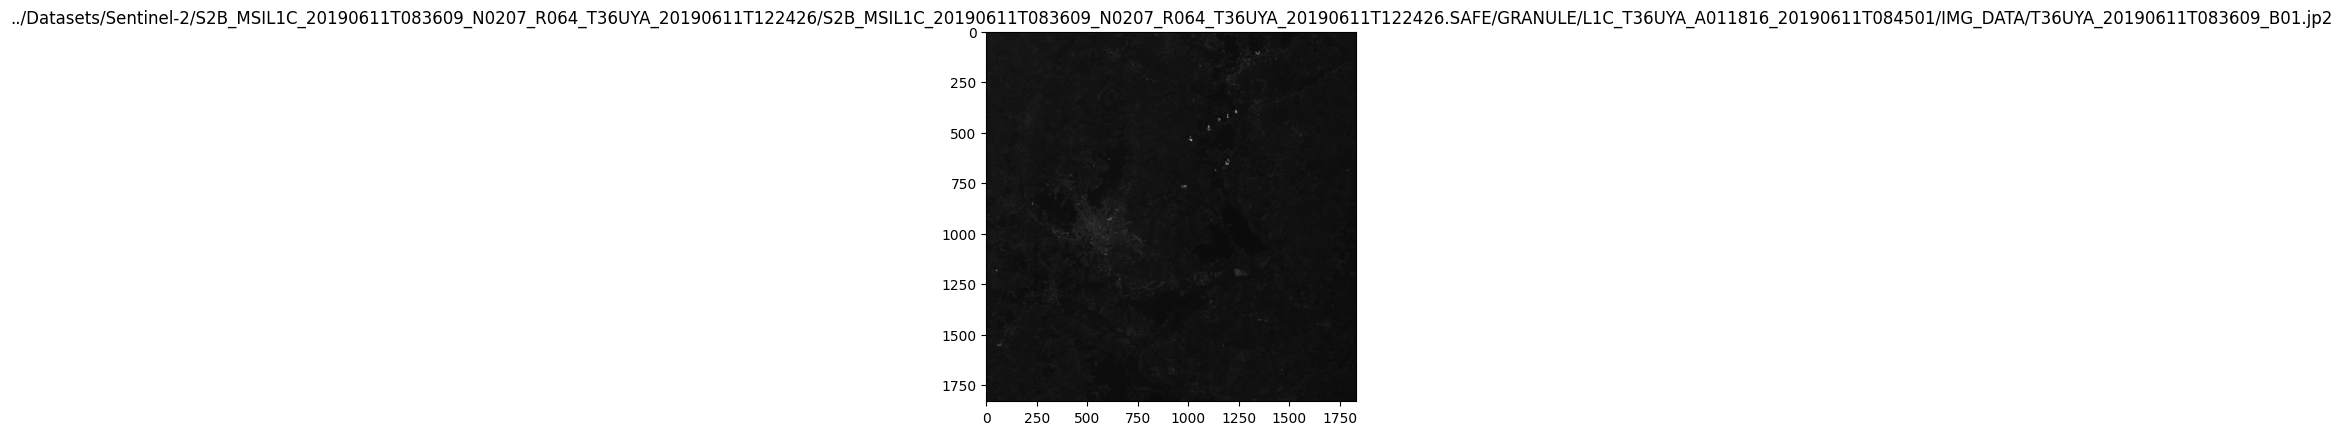

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(60.0, 0.0, 699960.0,
       0.0, -60.0, 5600040.0)}


In [17]:
# Get first key
example = jp2_files[9]

def visualize_band(jp2_path):
    with rasterio.open(jp2_path) as src:
        band = src.read(1)  # Read the first band
        plt.imshow(band, cmap="gray")
        plt.title(jp2_path)
        plt.show()

visualize_band(example)

# Open the .jp2 file
with rasterio.open(example) as dataset:
    # Read the dataset's data as a numpy array
    band_data = dataset.read(1)
    # Access metadata
    metadata = dataset.meta

print(metadata)

Dataset Summary:
--------------------------------------------------
Date range: 2016-02-12 08:40:52 to 2019-09-09 08:35:59
Number of unique tiles: 2
Number of satellites: 2

Satellite distribution:
satellite
S2A    33
S2B    17
Name: count, dtype: int64

Tile distribution:
tile_id
T36UYA    38
T36UXA    12
Name: count, dtype: int64


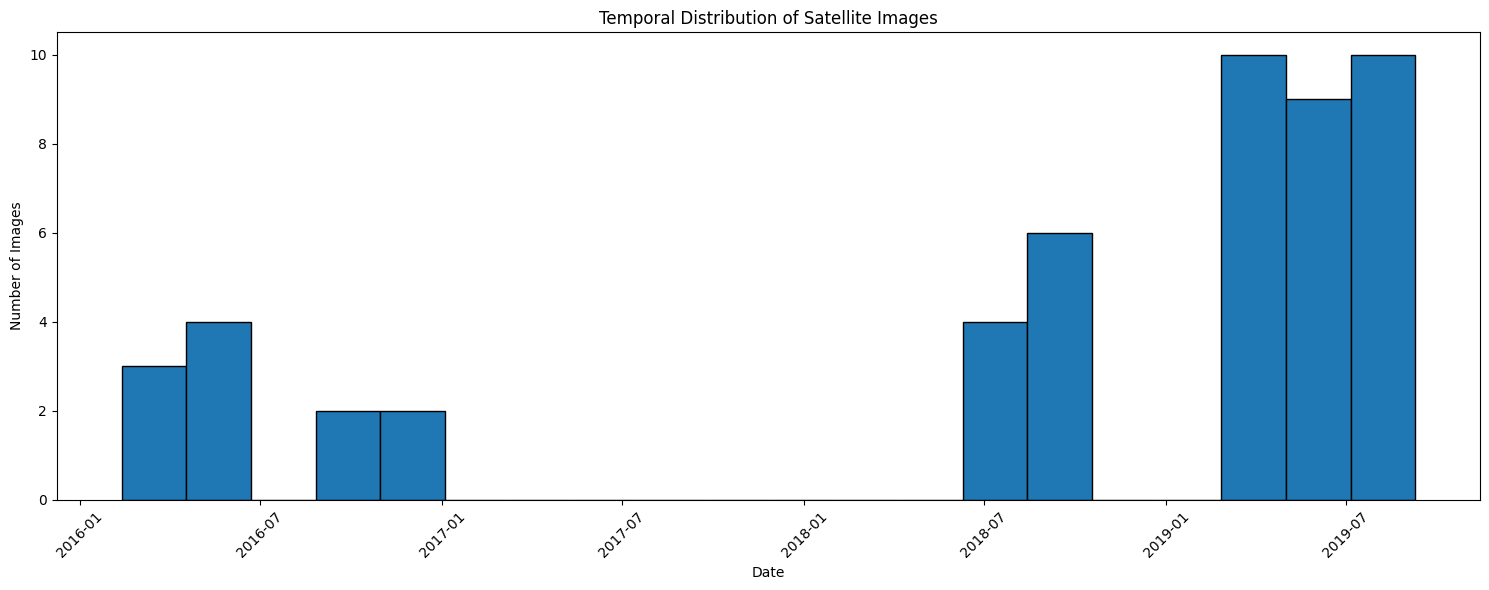

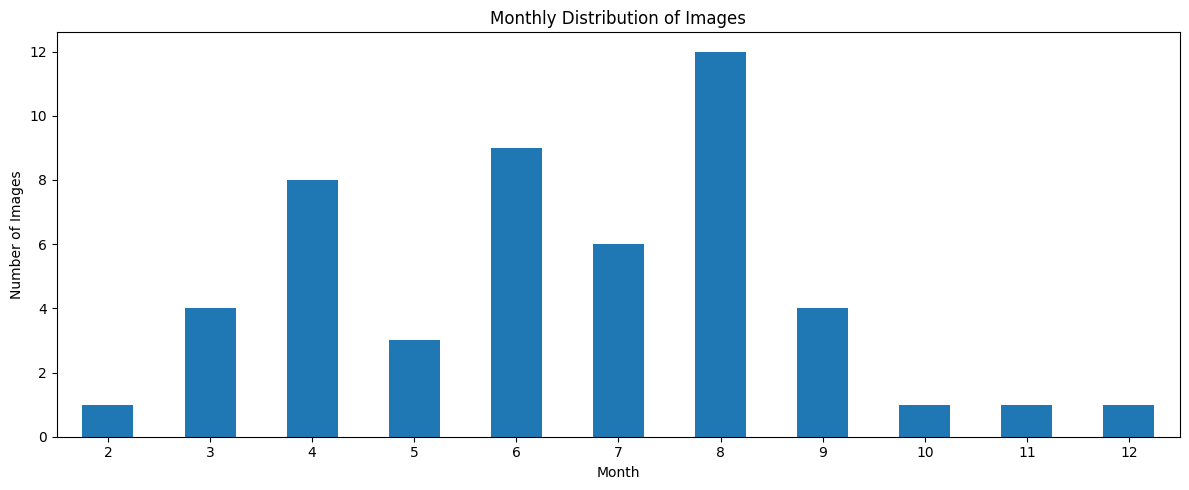

In [18]:
# Create a list to store metadata
metadata_list = []

for safe_dir in safe_dirs:
    # Parse directory name
    dir_parts = safe_dir.name.split('_')
    
    metadata = {
        'satellite': dir_parts[0],  # S2A or S2B
        'processing_level': dir_parts[1],  # MSIL1C
        'timestamp': datetime.strptime(dir_parts[2], '%Y%m%dT%H%M%S'),
        'relative_orbit': dir_parts[4],  # R064
        'tile_id': dir_parts[5],  # T36UYA
        'path': safe_dir
    }
    metadata_list.append(metadata)

# Create DataFrame
df_metadata = pd.DataFrame(metadata_list)

# Basic analysis
print("Dataset Summary:")
print("-" * 50)
print(f"Date range: {df_metadata['timestamp'].min()} to {df_metadata['timestamp'].max()}")
print(f"Number of unique tiles: {df_metadata['tile_id'].nunique()}")
print(f"Number of satellites: {df_metadata['satellite'].nunique()}")
print("\nSatellite distribution:")
print(df_metadata['satellite'].value_counts())
print("\nTile distribution:")
print(df_metadata['tile_id'].value_counts())

# Visualize temporal distribution
plt.figure(figsize=(15, 6))
plt.hist(df_metadata['timestamp'], bins=20, edgecolor='black')
plt.title('Temporal Distribution of Satellite Images')
plt.xlabel('Date')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly distribution
df_metadata['month'] = df_metadata['timestamp'].dt.month
monthly_counts = df_metadata['month'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
monthly_counts.plot(kind='bar')
plt.title('Monthly Distribution of Images')
plt.xlabel('Month')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
# Sample size calculation with confidence level
def calculate_strata_sizes(total_events=480, confidence_level=0.95, margin_error=0.1):
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    
    # Define strata bounds and proportions
    strata_bounds = [0, 3.37, 10.10, np.inf]  # hectares
    strata_props = [0.8, 0.15, 0.05]  # given proportions
    
    # Calculate sample sizes for each stratum
    sample_sizes = []
    for prop in strata_props:
        stratum_n = int(np.ceil((z_score**2 * prop * (1-prop)) / margin_error**2))
        sample_sizes.append(min(stratum_n, int(total_events * prop)))
    
    return sample_sizes

In [20]:
SPATIAL_THRESHOLD = 100  # meters
TEMPORAL_THRESHOLD = 20  # days
TILE_SIZE = 224  # pixels
TILE_OVERLAP = 0.20  # percentage

# Calculate effective ground sampling distance (GSD)
SENTINEL2_RESOLUTION = 10  # meters
TILE_GROUND_COVERAGE = TILE_SIZE * SENTINEL2_RESOLUTION  # meters

In [21]:
import geopandas as gpd
from shapely.ops import unary_union

def group_deforestation_events(gdf, spatial_thresh, temporal_thresh):
    # Create time-based groups
    gdf['temporal_group'] = pd.to_datetime(gdf['date']).dt.to_period('D')
    temporal_groups = gdf.groupby(pd.Grouper(key='temporal_group', freq=f'{temporal_thresh}D'))
    
    grouped_events = []
    for _, time_group in temporal_groups:
        if len(time_group) > 0:
            # Buffer and merge nearby polygons
            buffered = time_group.geometry.buffer(spatial_thresh)
            merged = unary_union(buffered)
            grouped_events.append(merged)
            
    return gpd.GeoDataFrame(geometry=grouped_events)

In [22]:
import datetime
# Define temporal window
temporal_window = [
    datetime.datetime(2018, 7, 15),
    datetime.datetime(2018, 9, 15)
]

In [23]:
def analyze_size_distribution(gdf):
    """Analyze the size distribution of events before sampling"""
    size_stats = {
        'small': len(gdf[gdf['area_ha'] <= 3.37]),
        'medium': len(gdf[(gdf['area_ha'] > 3.37) & (gdf['area_ha'] <= 10.10)]),
        'large': len(gdf[gdf['area_ha'] > 10.10])
    }
    return size_stats

def sample_deforestation_events(geojson_path, output_dir, temporal_window):
    # Read and initial processing
    gdf = gpd.read_file(geojson_path)
    
    # Log initial dataset size
    logging.info(f"Total events in dataset: {len(gdf)}")
    
    # Convert dates and filter for our temporal window
    gdf['img_date'] = pd.to_datetime(gdf['img_date'])
    mask = (gdf['img_date'] >= temporal_window[0]) & (gdf['img_date'] <= temporal_window[1])
    filtered_gdf = gdf[mask].copy()
    
    logging.info(f"Events in temporal window: {len(filtered_gdf)}")
    
    # Project to UTM and calculate area in hectares
    filtered_gdf = filtered_gdf.to_crs('EPSG:32736')  # UTM zone 36N for Ukraine
    filtered_gdf['area_ha'] = filtered_gdf.geometry.area / 10000
    
    # Analyze size distribution before sampling
    initial_distribution = analyze_size_distribution(filtered_gdf)
    logging.info("Initial size distribution:")
    logging.info(initial_distribution)
    
    # Define strata with adjusted sample sizes based on availability
    filtered_gdf['size_category'] = pd.cut(
        filtered_gdf['area_ha'],
        bins=[0, 3.37, 10.10, float('inf')],
        labels=['small', 'medium', 'large']
    )
    
    # Adjust sample sizes based on availability
    target_sizes = {'small': 50, 'medium': 15, 'large': 7}
    actual_sizes = {}
    
    for category, target in target_sizes.items():
        available = len(filtered_gdf[filtered_gdf['size_category'] == category])
        actual_sizes[category] = min(target, available)
        logging.info(f"{category}: Target={target}, Available={available}, Will sample={actual_sizes[category]}")
    
    # Stratified sampling with adjusted sizes
    sampled_events = pd.DataFrame()
    
    for category, size in actual_sizes.items():
        stratum = filtered_gdf[filtered_gdf['size_category'] == category]
        if len(stratum) > 0:
            sampled = stratum.sample(
                n=size, 
                random_state=42
            )
            sampled_events = pd.concat([sampled_events, sampled])
    
    # Convert back to GeoDataFrame and process
    sampled_events = gpd.GeoDataFrame(sampled_events, geometry='geometry')
    sampled_events = sampled_events.to_crs(4326)
    
    # Save results
    output_dir = Path(output_dir).resolve()
    output_dir.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = output_dir / f"sampled_events_{timestamp}.geojson"
    
    sampled_events.to_file(output_path, driver='GeoJSON')
    
    return sampled_events, output_path, initial_distribution

# Execute sampling
sampled_events, saved_path, initial_dist = sample_deforestation_events(
    geojson_path=geojson_path,
    output_dir=Path("../Datasets/Testing/Samples").resolve(),
    temporal_window=temporal_window
)

# Display comprehensive results
print("\nInitial Distribution in Temporal Window:")
for category, count in initial_dist.items():
    print(f"{category}: {count}")

print("\nFinal Sample Distribution:")
print(sampled_events['size_category'].value_counts())

print(f"\nSpatial Distribution:")
print(sampled_events.groupby('tile')['size_category'].count())

print(f"\nTemporal Distribution:")
print(sampled_events.groupby(sampled_events['img_date'].dt.strftime('%Y-%m-%d'))['size_category'].count())


Initial Distribution in Temporal Window:
small: 656
medium: 0
large: 0

Final Sample Distribution:
size_category
small     50
medium     0
large      0
Name: count, dtype: int64

Spatial Distribution:
tile
36UXA    50
Name: size_category, dtype: int64

Temporal Distribution:
img_date
2018-07-21     1
2018-07-26     3
2018-07-31     8
2018-08-05     7
2018-08-10     7
2018-08-15     3
2018-08-20     4
2018-08-25     1
2018-08-30    11
2018-09-04     2
2018-09-14     3
Name: size_category, dtype: int64


In [24]:
# First, let's analyze the raw data to understand the area distribution
def analyze_raw_distribution(geojson_path):
    gdf = gpd.read_file(geojson_path)
    gdf = gdf.to_crs('EPSG:32736')  # UTM zone 36N for Ukraine
    gdf['area_ha'] = gdf.geometry.area / 10000
    
    print("Area Statistics (hectares):")
    print(gdf['area_ha'].describe())
    
    print("\nQuantile Distribution:")
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    print(gdf['area_ha'].quantile(quantiles))
    
    # Count events by tile
    print("\nEvents per tile:")
    print(gdf['tile'].value_counts())
    
    # Temporal distribution by month
    gdf['month'] = pd.to_datetime(gdf['img_date']).dt.strftime('%Y-%m')
    print("\nEvents per month:")
    print(gdf['month'].value_counts().sort_index())
    
    return gdf

# Analyze full dataset
raw_data = analyze_raw_distribution(geojson_path)

# Let's adjust our size categories based on the actual distribution
def recalculate_size_thresholds(gdf, num_categories=3):
    quantiles = np.linspace(0, 1, num_categories + 1)[1:-1]
    thresholds = gdf['area_ha'].quantile(quantiles)
    
    print("\nProposed new size thresholds:")
    print(f"Small: <= {thresholds.iloc[0]:.2f} ha")
    print(f"Medium: {thresholds.iloc[0]:.2f} - {thresholds.iloc[1]:.2f} ha")
    print(f"Large: > {thresholds.iloc[1]:.2f} ha")
    
    return thresholds.tolist()

# Calculate new thresholds
new_thresholds = recalculate_size_thresholds(raw_data)

Area Statistics (hectares):
count    5696.000000
mean        2.382818
std         3.918158
min         0.001489
25%         0.307715
50%         1.272924
75%         2.941244
max        67.301044
Name: area_ha, dtype: float64

Quantile Distribution:
0.10     0.083259
0.25     0.307715
0.50     1.272924
0.75     2.941244
0.90     5.353595
0.95     7.574441
0.99    17.450756
Name: area_ha, dtype: float64

Events per tile:
tile
36UYA    3836
36UXA    1860
Name: count, dtype: int64

Events per month:
month
2016-01    3122
2016-02       6
2016-04      10
2016-05       2
2016-06      34
2016-07      40
2016-08      56
2016-10      28
2016-11       2
2016-12      18
2017-02       2
2017-08      13
2017-09      55
2017-10      17
2017-11      86
2018-01      47
2018-02     113
2018-03      45
2018-04      86
2018-05      50
2018-06     217
2018-07     169
2018-08     480
2018-09     117
2019-02       2
2019-03     227
2019-04     240
2019-05      34
2019-06     127
2019-07      59
2019-08     

In [25]:
def sample_deforestation_events_v3(geojson_path, output_dir, temporal_window):
    # Read and process data
    gdf = gpd.read_file(geojson_path)
    gdf['img_date'] = pd.to_datetime(gdf['img_date'])
    
    # Filter temporal window
    mask = (gdf['img_date'] >= temporal_window[0]) & (gdf['img_date'] <= temporal_window[1])
    filtered_gdf = gdf[mask].copy()
    
    # Calculate areas
    filtered_gdf = filtered_gdf.to_crs('EPSG:32736')
    filtered_gdf['area_ha'] = filtered_gdf.geometry.area / 10000
    
    # Define size categories
    filtered_gdf['size_category'] = pd.cut(
        filtered_gdf['area_ha'],
        bins=[0, 0.60, 2.35, float('inf')],
        labels=['small', 'medium', 'large']
    )
    
    # Calculate available events per category
    available = filtered_gdf['size_category'].value_counts()
    print("Available events per category:")
    print(available)
    
    # Define target samples (adjusted based on availability)
    target_samples = {
        'small': min(50, available['small']),
        'medium': min(15, available['medium']),
        'large': min(7, available.get('large', 0))  # Handle case if no large events
    }
    
    print("\nTarget samples per category:")
    print(target_samples)
    
    # Sample from each category
    sampled_events = pd.DataFrame()
    
    for category, target in target_samples.items():
        if target > 0:
            stratum = filtered_gdf[filtered_gdf['size_category'] == category]
            # Ensure even temporal distribution within each category
            sampled = stratum.groupby(stratum['img_date'].dt.to_period('M')).apply(
                lambda x: x.sample(
                    n=min(max(1, target // len(stratum['img_date'].dt.to_period('M').unique())),
                        len(x)),
                    random_state=42
                )
            ).reset_index(drop=True)
            
            # If we still need more samples, take them randomly from the remaining events
            if len(sampled) < target:
                remaining = stratum[~stratum.index.isin(sampled.index)]
                if len(remaining) > 0:
                    additional = remaining.sample(
                        n=min(target - len(sampled), len(remaining)),
                        random_state=42
                    )
                    sampled = pd.concat([sampled, additional])
            
            sampled_events = pd.concat([sampled_events, sampled])
    
    # Convert to GeoDataFrame and prepare for saving
    sampled_events = gpd.GeoDataFrame(sampled_events, geometry='geometry')
    sampled_events = sampled_events.to_crs(4326)
    
    # Save results
    output_dir = Path(output_dir).resolve()
    output_dir.mkdir(parents=True, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = output_dir / f"sampled_events_{timestamp}.geojson"
    sampled_events.to_file(output_path, driver='GeoJSON')

    # Print detailed statistics
    print("\nFinal sample distribution:")
    print("\nBy size category:")
    print(sampled_events['size_category'].value_counts())
    
    print("\nTemporal distribution:")
    print(sampled_events.groupby([
        sampled_events['img_date'].dt.strftime('%Y-%m'),
        'size_category'
    ], observed=True).size().unstack(fill_value=0))

    return sampled_events, output_path

# Execute sampling with new parameters
sampled_events_v3, saved_path = sample_deforestation_events_v3(
    geojson_path=geojson_path,
    output_dir=Path("../Datasets/Testing/Samples").resolve(),
    temporal_window=temporal_window
)

# Additional analysis of the results
print("\nArea statistics of sampled events:")
print(sampled_events_v3['area_ha'].describe())

print("\nDate distribution:")
print(sampled_events_v3['img_date'].dt.strftime('%Y-%m-%d').value_counts().sort_index())

Available events per category:
size_category
small     608
medium     47
large       1
Name: count, dtype: int64

Target samples per category:
{'small': 50, 'medium': 15, 'large': np.int64(1)}

Final sample distribution:

By size category:
size_category
small     50
medium    15
large      1
Name: count, dtype: int64

Temporal distribution:
size_category  small  medium  large
img_date                           
2018-07           18       5      0
2018-08           16       8      1
2018-09           16       2      0

Area statistics of sampled events:
count    66.000000
mean      0.441856
std       0.521227
min       0.021443
25%       0.104820
50%       0.238732
75%       0.546729
max       2.353282
Name: area_ha, dtype: float64

Date distribution:
img_date
2018-07-21     8
2018-07-26     5
2018-07-31    10
2018-08-05     3
2018-08-10     3
2018-08-15     1
2018-08-20     1
2018-08-25     1
2018-08-30    16
2018-09-04     5
2018-09-14    13
Name: count, dtype: int64


In [26]:
def visualize_sample_distribution(sampled_events):
    # Create a figure with 2x2 subplots, but only use 3
    fig = plt.figure(figsize=(15, 12))
    
    # Adjust the layout to use only 3 plots
    gs = plt.GridSpec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])  # top-left
    ax2 = fig.add_subplot(gs[0, 1])  # top-right
    ax3 = fig.add_subplot(gs[1, :])  # bottom, spanning both columns
    
    # Size category distribution
    sns.countplot(data=sampled_events, x='size_category', ax=ax1)
    ax1.set_title('Distribution by Size Category')
    ax1.set_ylabel('Count')
    
    # Temporal distribution
    sampled_events['date'] = pd.to_datetime(sampled_events['img_date']).dt.date
    sns.histplot(data=sampled_events, x='date', ax=ax2)
    ax2.set_title('Temporal Distribution')
    ax2.tick_params(axis='x', rotation=45)
    
    # Area distribution - make this plot wider
    sns.boxplot(data=sampled_events, y='area_ha', x='size_category', ax=ax3)
    ax3.set_title('Area Distribution by Category')
    ax3.set_ylabel('Area (hectares)')
    
    # Save metadata
    sample_metadata = {
        'total_samples': len(sampled_events),
        'temporal_range': {
            'start': str(sampled_events['img_date'].min()),
            'end': str(sampled_events['img_date'].max())
        },
        'size_distribution': sampled_events['size_category'].value_counts().to_dict(),
        'area_statistics': {
            'mean': float(sampled_events['area_ha'].mean()),
            'median': float(sampled_events['area_ha'].median()),
            'std': float(sampled_events['area_ha'].std())
        }
    }
    
    output_dir = Path("../Docs/Diagrams/")
    with open(output_dir / 'sample_metadata.json', 'w') as f:
        json.dump(sample_metadata, f, indent=2)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'sample_distribution.png')
    plt.close()

# Generate visualizations
visualize_sample_distribution(sampled_events_v3)

In [27]:
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import box
from rasterio.windows import from_bounds
import re
from pathlib import Path
import logging
import os
from PIL import Image
from tqdm.notebook import tqdm

class SentinelPatchProcessor:
    def __init__(self, patch_size=224):
        """
        Initialize the Sentinel-2 patch processor.
        
        Args:
            patch_size (int): Size of the output patches (default: 224)
        """
        self.patch_size = patch_size
        logging.basicConfig(
            level=logging.INFO,
            filename='processing.log',
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        
    def get_tile_id(self, sentinel_path):
        """Extract tile ID from Sentinel path"""
        match = re.search(r'T\d{2}[A-Z]{3}', str(sentinel_path))
        return match.group(0) if match else None
        
    def get_tile_bounds(self, sentinel_path):
        """Get the geographical bounds of a Sentinel tile"""
        sample_band = next(Path(sentinel_path).glob('GRANULE/*/IMG_DATA/*B02.jp2'))
        with rasterio.open(sample_band) as src:
            bounds = box(*src.bounds)
        return bounds
        
    def group_geometries_by_tile(self, geojson_path, sentinel_path):
        """Group geometries based on which tile they intersect with"""
        gdf = gpd.read_file(geojson_path)
        tile_bounds = self.get_tile_bounds(sentinel_path)
        tile_id = self.get_tile_id(sentinel_path)
        
        # Transform geometries to tile CRS if needed
        with rasterio.open(next(Path(sentinel_path).glob('GRANULE/*/IMG_DATA/*B02.jp2'))) as src:
            if gdf.crs != src.crs:
                gdf = gdf.to_crs(src.crs)
        
        # Filter geometries that intersect with this tile
        mask = gdf.geometry.intersects(tile_bounds)
        tile_geometries = gdf[mask].copy()
        
        # Clip geometries to tile bounds
        tile_geometries['geometry'] = tile_geometries.geometry.intersection(tile_bounds)
        
        return tile_geometries if not tile_geometries.empty else None

    def load_bands(self, sentinel_path):
        """Load and stack Sentinel-2 bands"""
        band_paths = list(Path(sentinel_path).glob('GRANULE/*/IMG_DATA/*.jp2'))
        band_data = {}
        required_bands = ['B02', 'B03', 'B04', 'B08', 'B8A', 'B11', 'B12']
        
        for band_path in band_paths:
            band_name = re.search(r'B\d{2}|B8A', band_path.name)
            if band_name:
                band_name = band_name.group(0)
                if band_name in required_bands:
                    try:
                        with rasterio.open(band_path) as src:
                            band_data[band_name] = src.read(1)
                            if band_name == 'B02':
                                self.meta = src.meta.copy()
                            logging.info(f"Loaded band {band_name} from {self.get_tile_id(sentinel_path)}")
                    except Exception as e:
                        logging.error(f"Error loading {band_name} from {sentinel_path}: {str(e)}")
        
        if len(band_data) != len(required_bands):
            missing_bands = set(required_bands) - set(band_data.keys())
            logging.error(f"Missing required bands for {self.get_tile_id(sentinel_path)}: {missing_bands}")
            return None
            
        return band_data

    def validate_bands(self, band_data, required_bands):
        """Validate that all required bands are present"""
        missing_bands = [band for band in required_bands if band not in band_data]
        if missing_bands:
            raise ValueError(f"Missing required bands: {missing_bands}")

    def resample_to_10m(self, band_data):
        """Resample all bands to 10m resolution"""
        try:
            # Get shape from a 10m band (B02)
            target_shape = band_data['B02'].shape
            logging.debug(f"Target shape for resampling: {target_shape}")
            
            # Bands that need resampling (20m bands)
            bands_to_resample = ['B8A', 'B11', 'B12']
            
            for band in bands_to_resample:
                if band in band_data and band_data[band].shape != target_shape:
                    logging.info(f"Resampling {band} to 10m resolution")
                    band_data[band] = self._resample_array(
                        band_data[band],
                        target_shape
                    )
                    logging.debug(f"Resampled {band} shape: {band_data[band].shape}")
                    
            return band_data
            
        except Exception as e:
            logging.error(f"Error in resample_to_10m: {str(e)}")
            raise

    def _resample_array(self, array, target_shape):
        """Helper function to resample arrays using bilinear interpolation"""
        try:
            # Convert array to PIL Image for resampling
            img = Image.fromarray(array)
            
            # Resize to target shape (note the order: width, height)
            resized = img.resize(
                (target_shape[1], target_shape[0]),  # PIL uses (width, height)
                resample=Image.BILINEAR
            )
            
            # Convert back to numpy array
            return np.array(resized)
            
        except Exception as e:
            logging.error(f"Error in _resample_array: {str(e)}")
            raise

    def compute_indices(self, band_data):
        """
        Compute NDVI and NDMI indices from Sentinel-2 bands with safe division
        """
        try:
            # Validate required bands
            required_bands = ['B04', 'B08', 'B8A', 'B11']
            self.validate_bands(band_data, required_bands)
            
            # Calculate NDVI safely
            nir_red_sum = band_data['B08'] + band_data['B04']
            nir_red_diff = band_data['B08'] - band_data['B04']
            
            # Use np.divide with where condition to handle zeros
            ndvi = np.divide(
                nir_red_diff, 
                nir_red_sum, 
                out=np.zeros_like(nir_red_diff, dtype=np.float32),
                where=nir_red_sum != 0
            )
            
            # Calculate NDMI safely
            nir_swir_sum = band_data['B8A'] + band_data['B11']
            nir_swir_diff = band_data['B8A'] - band_data['B11']
            
            # Use np.divide with where condition to handle zeros
            ndmi = np.divide(
                nir_swir_diff, 
                nir_swir_sum, 
                out=np.zeros_like(nir_swir_diff, dtype=np.float32),
                where=nir_swir_sum != 0
            )
            
            # Add bounds to prevent extreme values
            ndvi = np.clip(ndvi, -1, 1)
            ndmi = np.clip(ndmi, -1, 1)
            
            # Replace NaN values with 0
            ndvi = np.nan_to_num(ndvi, nan=0.0)
            ndmi = np.nan_to_num(ndmi, nan=0.0)
            
            logging.info(f"Successfully computed NDVI and NDMI indices")
            logging.debug(f"NDVI range: [{ndvi.min():.3f}, {ndvi.max():.3f}]")
            logging.debug(f"NDMI range: [{ndmi.min():.3f}, {ndmi.max():.3f}]")
            
            return ndvi, ndmi
            
        except Exception as e:
            logging.error(f"Error computing indices: {str(e)}")
            raise

    def create_patches(self, stacked_bands, geometries, output_dir):
        """Create and save image patches for each geometry"""
        try:
            os.makedirs(output_dir, exist_ok=True)
            
            for idx, geometry in geometries.iterrows():
                try:
                    bounds = geometry.geometry.bounds
                    window = from_bounds(*bounds, transform=self.meta['transform'])
                    
                    patch = stacked_bands[
                        :,
                        int(window.row_off):int(window.row_off + self.patch_size),
                        int(window.col_off):int(window.col_off + self.patch_size)
                    ]
                    
                    if patch.shape[1:] == (self.patch_size, self.patch_size):
                        output_path = Path(output_dir) / f"patch_{idx}.npy"
                        np.save(output_path, patch)
                        logging.info(f"Saved patch {idx} to {output_path}")
                    else:
                        logging.warning(f"Skipping patch {idx} due to incorrect size: {patch.shape[1:]}")
                        
                except Exception as e:
                    logging.error(f"Error processing patch {idx}: {str(e)}")
                    continue
                    
        except Exception as e:
            logging.error(f"Error in create_patches: {str(e)}")
            raise

    def process_imagery(self, sentinel_path, geojson_path, output_dir):
        """Process imagery considering tile boundaries"""
        try:
            tile_id = self.get_tile_id(sentinel_path)
            if not tile_id:
                logging.error(f"Could not determine tile ID for {sentinel_path}")
                return

            # Group geometries by tile
            tile_geometries = self.group_geometries_by_tile(geojson_path, sentinel_path)
            if tile_geometries is None:
                logging.info(f"No geometries intersect with tile {tile_id}")
                return

            # Create output directory for this tile
            tile_output_dir = Path(output_dir) / tile_id
            os.makedirs(tile_output_dir, exist_ok=True)

            # Load and process bands
            band_data = self.load_bands(sentinel_path)
            if band_data is None:
                return

            band_data = self.resample_to_10m(band_data)
            ndvi, ndmi = self.compute_indices(band_data)
            
            stacked_bands = np.stack([
                band_data['B02'], band_data['B03'], band_data['B04'],
                band_data['B08'], band_data['B8A'], band_data['B11'],
                band_data['B12'], ndvi, ndmi
            ])
            
            self.create_patches(stacked_bands, tile_geometries, tile_output_dir)
            logging.info(f"Successfully processed tile {tile_id}")
            
        except Exception as e:
            logging.error(f"Error processing tile {tile_id}: {str(e)}")
            raise

In [ ]:
# Initialize processor
processor = SentinelPatchProcessor(patch_size=224)

# Get all .SAFE directories
base_path = Path("../Datasets/Sentinel-2")
safe_dirs = list(base_path.glob("*/*.SAFE"))

# Process each Sentinel-2 scene
for safe_dir in tqdm(safe_dirs, desc="Processing Sentinel-2 images"):
    try:
        processor.process_imagery(
            sentinel_path=str(safe_dir),
            geojson_path=saved_path,
            output_dir=f"../Datasets/Testing/Tiles/{safe_dir.parent.name}"
        )
    except Exception as e:
        logging.error(f"Failed to process {safe_dir}: {str(e)}")
        continue

Processing Sentinel-2 images:   0%|          | 0/50 [00:00<?, ?it/s]